<a href="https://colab.research.google.com/github/aylnakyz/NLP2025_Ex2/blob/main/NLP2025_Exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

%matplotlib inline

In [56]:
# Downloading US cities dataset and loading it into a dataframe
url = 'https://raw.githubusercontent.com/aylnakyz/NLP2025_Ex2/28ffd6ce374acfceb55d483d4e89dd99d6d65558/uscitynames.csv'
df = pd.read_csv(url)
#df.head()

# Turning the 'uscity' column into a lowercase list of city names
uscitynames_lowercase = df['uscity'].str.lower().tolist()
words = [city for city in uscitynames_lowercase if not any(char.isdigit() for char in city)]

# Creating a list of cities
words = [city for city in uscitynames_lowercase]

# Printing the list and its length
print(words)
print("Length of uscitynames list:", len(words))


['new york', 'los angeles', 'chicago', 'miami', 'houston', 'dallas', 'philadelphia', 'atlanta', 'washington', 'boston', 'phoenix', 'detroit', 'seattle', 'san francisco', 'san diego', 'minneapolis', 'tampa', 'brooklyn', 'denver', 'queens', 'riverside', 'las vegas', 'baltimore', 'st. louis', 'portland', 'san antonio', 'sacramento', 'austin', 'orlando', 'san juan', 'san jose', 'indianapolis', 'pittsburgh', 'cincinnati', 'manhattan', 'kansas city', 'cleveland', 'columbus', 'bronx', 'charlotte', 'virginia beach', 'jacksonville', 'milwaukee', 'providence', 'nashville', 'salt lake city', 'raleigh', 'richmond', 'memphis', 'oklahoma city', 'hartford', 'louisville', 'buffalo', 'fort worth', 'bridgeport', 'new orleans', 'tucson', 'el paso', 'omaha', 'mcallen', 'birmingham', 'albuquerque', 'tulsa', 'charleston', 'fresno', 'rochester', 'dayton', 'cape coral', 'provo', 'colorado springs', 'mission viejo', 'allentown', 'baton rouge', 'ogden', 'knoxville', 'grand rapids', 'columbia', 'albany', 'bakers

In [81]:
# Build the vocabulary of characters, keeping only letters and spaces
chars = sorted(list(set(c for c in ''.join(words) if c.isalpha())))


# Create mappings to/from integers
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0  # Keep the dot as a special symbol (optional)
itos = {i:s for s,i in stoi.items()}

print(itos)
print("Vocabulary size:", len(itos))

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: 'á', 28: 'é', 29: 'í', 30: 'ñ', 31: 'ó', 32: 'ú', 33: 'ü', 0: '.'}
Vocabulary size: 34


In [82]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      if ch in stoi:
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
      else:
          # Handle the unknown character, for example by skipping it or replacing it
          # with a special token
          pass # skip the unknown character

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([244134, 3]) torch.Size([244134])
torch.Size([30740, 3]) torch.Size([30740])
torch.Size([30603, 3]) torch.Size([30603])


In [88]:
vocab_size = len(itos) #To adjust the embedding matrix size
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]

In [89]:
sum(p.nelement() for p in parameters) # number of parameters in total

13374

In [90]:
for p in parameters:
  p.requires_grad = True

In [91]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [92]:
lri = []
lossi = []
stepi = []

In [93]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

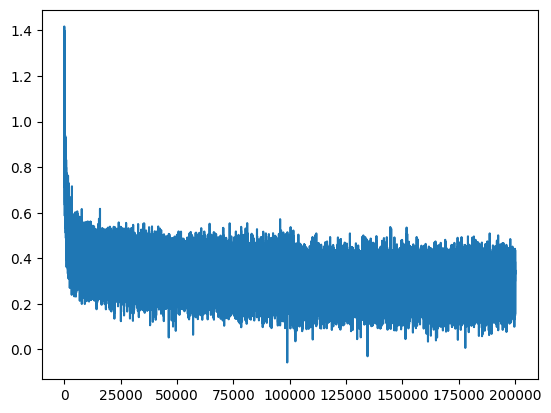

In [94]:
plt.plot(stepi, lossi)

In [95]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9694, grad_fn=<NllLossBackward0>)

In [96]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0171, grad_fn=<NllLossBackward0>)

In [97]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.0028, grad_fn=<NllLossBackward0>)

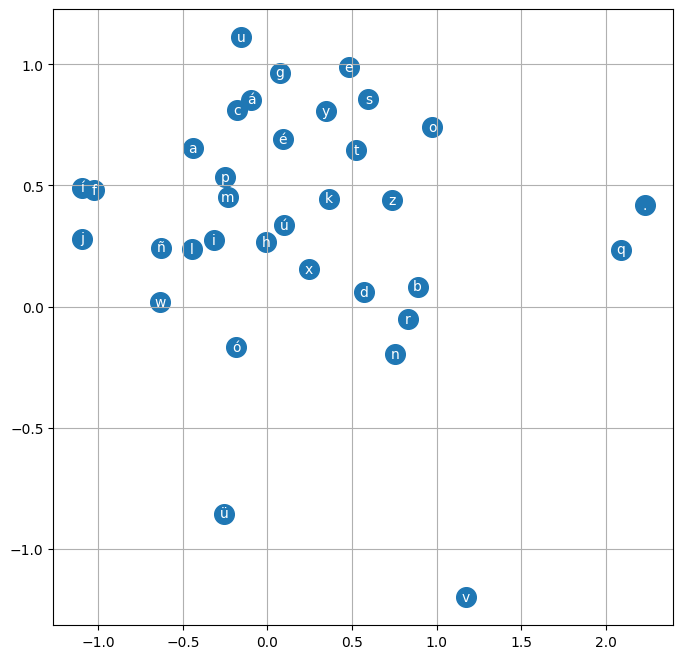

In [98]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [99]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

montainharline.
medhollageenvallendramo.
licherselingsmilter.
edensvalle.
ravilliverter.
nosadborgahimbert.
tulle.
lospentercoon.
mance.
riy.
hullehghills.
honneda.
hille.
lydaluff.
brook.
unen.
creensvilosteportbradown.
obingpark.
sumunawh.
hurcreens.
